In [1]:
!pip install pytorch-ignite -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 17.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers


In [3]:
DATA_DIR='./data' # データ保存用のディレクトリ
IMAGE_SIZE = 32 # 入力画像1辺のサイズ
NUM_CLASSES = 100 # 分類するクラスの数
NUM_WORKERS = 8 # データローダーが使用するサブプロセスの数を指定
BATCH_SIZE = 32 # ミニバッチのサイズ
EPOCHS = 150 # 学習回数
LEARNING_RATE = 1e-3 # 最大学習率
WEIGHT_DECAY = 1e-1 # オプティマイザーの重み減衰率


In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)


device: cuda


In [5]:
# トレーニングデータに適用する一連の変換操作をtransforms.Composeにまとめる
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # ランダムに左右反転
    # 4ピクセルのパディングを挿入してランダムに切り抜く
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    # 画像のコントラスト、彩度、色相をランダムに変化させる
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor() # テンソルに変換
])


In [6]:
# CIFAR-100データセットのトレーニングデータを読み込み、データ拡張を適用
train_dset = datasets.CIFAR100(
    root=DATA_DIR, train=True, download=True, transform=train_transform)
# CIFAR-100データセットのテストデータを読み込んでテンソルに変換する処理のみを行う
test_dset = datasets.CIFAR100(
    root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())


100%|██████████| 169001437/169001437 [00:12<00:00, 13216642.02it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
# トレーニング用のデータローダーを作成
train_loader = torch.utils.data.DataLoader(
    train_dset,
    batch_size=BATCH_SIZE,
    shuffle=True, # 抽出時にシャッフルする
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )

# テスト用のデータローダーを作成
test_loader = torch.utils.data.DataLoader(
    test_dset,
    batch_size=BATCH_SIZE,
    shuffle=False, # 抽出時にシャッフルしない
    num_workers=NUM_WORKERS, # データ抽出時のサブプロセスの数を指定
    pin_memory=True # データを固定メモリにロード
    )


In [8]:
class LayerNormChannels(nn.Module):
    """ チャンネル次元に対して正規化を適用する

    """
    def __init__(self, channels):
        """
        Args:
            channels (int): 特徴テンソルのチャンネル数
        """
        super().__init__()
        self.norm = nn.LayerNorm(channels)

    def forward(self, x):
        """ フォワードパス

        Args:
            x : 特徴テンソル
                (bs, channels, height, width)
        Returns:
            x: 正規化適用後の特徴テンソル
        """
        # 第2次元（channels）と最後の次元（width）を入れ替える
        x = x.transpose(1, -1)
        # チャンネル次元に対して正規化の処理を適用
        x = self.norm(x)
        # テンソルの形状を元に戻す
        x = x.transpose(-1, 1)
        return x


In [9]:
class Residual(nn.Module):
    """ 与えられたブロックに対して残差接続を適用する

    """
    def __init__(self, *layers):
        """
        Args:
            layers (nn.Module): 複数のレイヤー
        """
        super().__init__()
        # 渡されたレイヤーをSequentialオブジェクトにまとめる
        self.residual = nn.Sequential(*layers)
        # スケーリングパラメーターを初期化
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        """ フォワードパス

        Args:
            x (torch.Tensor): 特徴テンソル
                形状は (batch_size, channels, height, width)
        Returns:
            入力テンソルにスケーリングされた残差を加算した出力テンソル
        """
         # 残差接続の出力を返す
        return x + self.gamma * self.residual(x)


In [10]:
def SpatialMixer(channels, kernel_size, stride=1):
    """ 各チャンネルに対して独立した畳み込みを適用するConv2dレイヤーを作成

    Args:
        channels (int): 入力テンソルのチャンネル数
        kernel_size (int): 畳み込みカーネルのサイズ
        stride (int, optional): 畳み込みのストライド（デフォルトは1）

    Returns:
        nn.Conv2d: 指定されたパラメータで構築されたConv2dレイヤー
    """
    # カーネルサイズに基づいてパディングを計算（出力のサイズを保つため）
    padding = (kernel_size - 1) // 2

    return nn.Conv2d(channels,        # 入力チャンネル数
                     channels,        # 出力チャンネル数(入力と同じ)
                     kernel_size,     # 畳み込みカーネルのサイズ
                     padding=padding, # 計算されたパディングを適用
                     stride=stride,   # 畳み込みのストライド
                     groups=channels) # グループ数をチャンネル数と同じに設定


In [11]:
class ChannelMixer(nn.Sequential):
    """ 入力テンソルのチャンネル間で情報を混合するためのブロックを構築

    """
    def __init__(self, channels, mult=4):
        """
        Args:
            channels (int): 特徴テンソルのチャンネル数
            mult (int): 中間層のチャンネル数を決定するための倍率
        """
        # 中間層のチャンネル数を計算
        mid_channels = channels * mult
        # スーパークラス(nn.Sequential)のコンストラクターにレイヤーを渡す
        super().__init__(
            # チャンネル次元の正規化を行うレイヤーを配置
            LayerNormChannels(channels),
            # 1x1の畳み込みでチャンネル数を増加させるConv2dレイヤーを配置
            nn.Conv2d(channels, mid_channels, 1),
            nn.GELU(), # GELU活性化関数を適用
            # 1x1の畳み込みで元のチャンネル数に戻すConv2dレイヤーを配置
            nn.Conv2d(mid_channels, channels, 1)
        )


In [12]:
class ConvEncoder(Residual):
    """ 画像データにエンコード処理を行う残差接続ブロックを構築

    """
    def __init__(self, channels, kernel_size, p_drop=0.):
        """
        Args:
            channels (int): 入力テンソルのチャンネル数
            kernel_size (int): 畳み込みカーネルのサイズ
            p_drop (float): ドロップアウト率（デフォルトは0）
        """
        # Residualクラスのコンストラクターに各ブロック、レイヤーを渡す
        super().__init__(
            # 各チャンネルに対して独立した畳み込みを適用するSpatialMixerを配置
            SpatialMixer(channels, kernel_size),
            # チャンネル間の情報を混合するChannelMixerを配置
            ChannelMixer(channels),
            nn.Dropout(p_drop) # ドロップアウトを配置
        )


In [13]:
class XCA(nn.Module):
    """ クロスチャンネル注意機構（Cross-Channel Attention）を実装するクラス

    Attributes:
        heads (int): 注意機構のヘッド数: 4,
        head_channels (int): 各ヘッドのチャンネル数: 16, 32, 64,
        to_keys (nn.Conv2d): 入力テンソルをキーに変換する1x1畳み込み層
        to_queries (nn.Conv2d): 入力テンソルをクエリに変換する1x1畳み込み層
        to_values (nn.Conv2d): 入力テンソルをバリューに変換する1x1畳み込み層
        unifyheads (nn.Conv2d): 各ヘッドの出力を統合する1x1畳み込み層
        temperature (nn.Parameter): スケーリングに使用するパラメーター
    """
    def __init__(self, channels, heads):
        """
        Args:
            channels (int): 入力テンソルのチャンネル数
            heads (int): 注意機構のヘッド数
        """
        super().__init__()
        self.heads = heads  # ヘッド数を設定
        self.head_channels = channels // heads  # 各ヘッドのチャンネル数を計算

        # キーを生成する1x1畳み込み層
        self.to_keys = nn.Conv2d(channels, channels, 1)
        # クエリを生成する1x1畳み込み層
        self.to_queries = nn.Conv2d(channels, channels, 1)
        # バリューを生成する1x1畳み込み層
        self.to_values = nn.Conv2d(channels, channels, 1)
        # 各ヘッドの出力を統合する1x1畳み込み層
        self.unifyheads = nn.Conv2d(channels, channels, 1)
        # スケーリングパラメータを初期化
        self.temperature = nn.Parameter(torch.ones(heads, 1, 1))

    def forward(self, x):
        """ フォワードパス

        Args:
            x: 入力テンソル(bs, チャンネル数, 高さ,幅)
               (bs, 64, 16, 16), (bs, 128, 8, 8), (bs, 256, 4, 4)
        Returns:
            クロスチャネル注意機構適後のアテンション重み付きテンソル
            (bs, 64, 16, 16), (bs, 128, 8, 8), (bs, 256, 4, 4)
        """
        b, _, h, w = x.shape  # バッチサイズ、高さ、幅を取得

        # self.heads=4, self.head_channels=16, 32, 64
        # keys,values,queriesの形状: (bs, 4, 16, 256)
        #                            (bs, 4, 32, 64)
        #                            (bs, 4, 64, 16)
        #
        # キーを生成し、ヘッドごとに分割
        keys = self.to_keys(x).view(b, self.heads, self.head_channels, -1)
        # バリューを生成し、ヘッドごとに分割
        values = self.to_values(x).view(b, self.heads, self.head_channels, -1)
        # クエリを生成し、ヘッドごとに分割
        queries = self.to_queries(x).view(b, self.heads, self.head_channels, -1)

        queries = F.normalize(queries, dim=-2)  # クエリを正規化
        keys = F.normalize(keys, dim=-2)  # キーを正規化

        # アテンションスコアを計算
        # attnの形状: (bs, 4, 16, 16)
        #             (bs, 4, 32, 32)
        #             (bs, 4, 64, 64)
        attn = queries @ keys.transpose(-2, -1)
        # スケーリングパラメーターを適用
        attn = attn * self.temperature
        # ソフトマックス関数を適用
        attn = F.softmax(attn, dim=-1)

        # アテンションスコアをバリューに適用
        # outの形状: (bs, 4, 16, 256)
        #            (bs, 4, 32, 64)
        #            (bs, 4, 64, 16)
        out = attn @ values

        # テンソルの形状を整形
        # outの形状: (bs, 64, 16, 16)
        #            (bs, 128, 8, 8)
        #            (bs, 256, 4, 4)
        out = out.view(b, -1, h, w)

        # 各ヘッドの出力を統合
        out = self.unifyheads(out)

        return out


In [14]:
class MultiScaleSpatialMixer(nn.Module):
    """ 複数のスケールで空間的な特徴を抽出し、混合する処理を行う

    Attributes:
        scales (int): スケールの数
        convs (nn.ModuleList): 各スケールでの畳み込み層のリスト
    """
    def __init__(self, channels, scales=1):
        """
        Args:
            channels (int): 入力テンソルのチャンネル数
            scales (int): スケールの数（デフォルトは1）
        """
        super().__init__()
        self.scales = scales  # スケールの数を設定

        # 各スケールに割り当てるチャンネル数を計算
        subset_channels = (
            channels // scales +
            (1 if channels % scales != 0 else 0)
        )

        # 各スケールでの畳み込み層をリストに追加
        self.convs = nn.ModuleList([
            SpatialMixer(subset_channels, 3)
            for _ in range(scales - 1)
        ])

    def forward(self, x):
        """ フォワードパス

        Args:
            x : 入力テンソル
                1.(bs, 64, 16, 16)
                2.(bs, 128, 8, 8)
                3.(bs, 256, 4, 4)
        Returns:
            out: スケールごとの空間的な特徴を混合した出力テンソル
                  1.(bs, 64, 16, 16)
                  2.(bs, 128, 8, 8)
                  3.(bs, 256, 4, 4)
        """
        # 入力テンソルのチャンネル次元をself.scalesの数に分割
        # 1.(bs, 64, 16, 16) -> self.scales=2 -> (bs, 32, 16, 16) x 2
        # 2.(bs, 128, 8, 8) -> self.scales=4 -> (bs, 32, 8, 8) x 4
        # 3.(bs, 256, 4, 4) -> self.scales=4 -> (bs, 64, 4, 4) x 4
        splits = x.chunk(self.scales, dim=1)

        # 最後の分割を出力テンソルoutの初期値として設定
        # outの形状: 1.(bs, 32, 16, 16)
        #            2.(bs, 32, 8, 8)
        #            3.(bs, 64, 4, 4)
        out = splits[-1]

        # 畳み込み層の出力を保持する変数を初期化
        s = 0.

        # 各チャンネルグループに対してチャンネルごとに独立した畳み込みを適用
        #
        # 1. Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=32) x 1
        # (bs, 32, 16, 16)に1 x Conv2dの出力(bs, 32, 16, 16)をチャンネル次元で結合
        # outの形状: (bs, 64, 16, 16)
        #
        # 2. Conv2d(32, 32, kernel_size=3, stride=1, padding=1, groups=32) x 3
        # (bs, 32, 8, 8)にConv2dの出力(bs, 32, 8, 8) x 3をチャンネル次元で結合
        # outの形状: (bs, 128, 16, 16)
        #
        # 3. Conv2d(64, 64, kernel_size=3, stride=1, padding=1, groups=64) x 3
        # (bs, 64, 4, 4)にConv2dの出力(bs, 64, 4, 4) x 3をチャンネル次元で結合
        # outの形状: (bs, 256, 4, 4)
        for conv, split in zip(self.convs, splits):
            # 各スケール(チャンネルグループ)ごとに、前回の出力を加算して畳み込み層に入力
            s = conv(split + s)
            # 繰り返し1回目:
            # 初期値のテンソル(out)と現在の畳み込み出力(s)をチャンネル次元で連結
            # 繰り返し2回目以降:
            # 前回の出力テンソル(out)と現在の畳み込み出力(s)をチャンネル次元で連結
            out = torch.cat((out, s), dim=1)

        return out


In [15]:
class SDTAEncoder(Residual):
    """ エンコーダーを構築する

    MultiScaleSpatialMixer: 複数のスケールでの空間的な特徴混合を行うモジュール
    XCA: クロスチャンネル注意機構を適用するモジュール
    ChannelMixer: チャンネル間で情報を混合するモジュール
    """
    def __init__(self, channels, heads, scales=1, p_drop=0.):
        """
        Args:
            channels (int): 入力テンソルのチャンネル数
            heads (int): アテンションヘッドの数
            scales (int): スケールの数
            p_drop (float): ドロップアウト率
        """
        # Residualのコンストラクターに各モジュールのインスタンスを渡す
        super().__init__(
            # 複数のスケールで空間的な特徴を混合するMultiScaleSpatialMixer
            MultiScaleSpatialMixer(channels, scales),
            # 残差接続を追加
            Residual(
                # チャンネル次元に正規化を適用するLayerNormChannels
                LayerNormChannels(channels),
                # クロスチャンネル注意機構を適用するXCA
                XCA(channels, heads)
            ),
            # チャンネル間で情報を混合するChannelMixer
            ChannelMixer(channels),
            nn.Dropout(p_drop)  # ドロップアウト
        )


In [16]:
class DownsampleBlock(nn.Sequential):
    """ 入力テンソルの空間的な解像度を縮小するブロック
    """
    def __init__(self, in_channels, out_channels, stride=2):
        """
        Args:
            in_channels (int): 入力テンソルのチャンネル数
            out_channels (int): 出力テンソルのチャンネル数
            stride (int): 畳み込みのストライド
        """
        # nn.Sequentialのコンストラクターにレイヤーを渡す
        super().__init__(
            # 入力テンソルのチャンネル次元に正規化を適用
            LayerNormChannels(in_channels),
            # 畳み込み層を適用してダウンサンプリング
            nn.Conv2d(in_channels, out_channels, stride, stride=stride)
        )


In [17]:
class Stage(nn.Sequential):
    """ ステージを構築する

    """
    def __init__(self, in_channels, out_channels, num_blocks,
                 kernel_size, p_drop=0.,
                 global_block=False, global_block_kwargs={}):
        """
        Args:
            in_channels (int): 入力テンソルのチャンネル数
            out_channels (int): 出力テンソルのチャンネル数
            num_blocks (int): 畳み込みエンコーダブロックの数
            kernel_size (int): 畳み込みカーネルのサイズ
            p_drop (float): ドロップアウト率
            global_block (bool): グローバルエンコーダーブロックを含むかどうか
            global_block_kwargs (dict): グローバルエンコーダーブロックの追加引数
        """
        # 入力チャンネルと出力チャンネルが異なる場合、DownsampleBlockを追加
        layers = [] if in_channels == out_channels else [
            DownsampleBlock(in_channels, out_channels)
        ]
        # 畳み込みエンコーダーブロックConvEncoderをnum_blocksの数だけ追加
        layers += [
            ConvEncoder(out_channels, kernel_size, p_drop=p_drop)
            for _ in range(num_blocks)
        ]
        # グローバルエンコーダーブロックを使用の場合(global_block=True)、SDTAEncoderを追加
        if global_block:
            layers.append(SDTAEncoder(out_channels, **global_block_kwargs))

        # nn.Sequentialのコンストラクターにlayersを渡す
        super().__init__(*layers)


In [18]:
class EdgeNeXtBody(nn.Sequential):
    """ EdgeNeXtモデルのボディ部分を構築する

    """
    def __init__(self, in_channels, channel_list,
                 num_blocks_list, kernel_size_list,
                 global_block_list, scales_list, heads, p_drop=0.):
        """
        Args:
            in_channels: 入力テンソルのチャンネル数
            channel_list: 各ステージの出力チャンネル数のリスト
            num_blocks_list: 各ステージのブロック数のリスト
            kernel_size_list: 各ステージのカーネルサイズのリスト
            global_block_list: 各ステージでグローバルブロックを使用するかどうかのリスト
            scales_list: 各ステージのスケール数のリスト
            heads (int): アテンションヘッドの数
            p_drop (float): ドロップアウト率
        """
        layers = []  # レイヤーリストを初期化
        # 各パラメーターをzipでまとめて一つの反復可能オブジェクトにする
        params = zip(
            channel_list,
            num_blocks_list,
            kernel_size_list,
            global_block_list,
            scales_list
        )

        # paramsに対して反復処理
        for out_channels, num_blocks, kernel_size, global_block, scales in params:
            # グローバルブロックの引数を設定
            global_block_kwargs = (
                dict(scales=scales, heads=heads, p_drop=p_drop)
                if global_block else {}
            )
            # 各ステージをレイヤーリストに追加
            layers.append(
                Stage(
                    in_channels,
                    out_channels,
                    num_blocks,
                    kernel_size,
                    p_drop,
                    global_block,
                    global_block_kwargs
                )
            )
            # 次のステージの入力チャンネル数を更新
            in_channels = out_channels

        # nn.Sequentialのコンストラクターにレイヤーリストを渡す
        super().__init__(*layers)


In [19]:
class Stem(nn.Sequential):
    """ EdgeNeXtモデルにおいて先頭に配置される畳み込みブロック
        データセットの画像を入力し、初期の特徴マップを生成
    """
    def __init__(self, in_channels, out_channels, patch_size):
        """
        Args:
            in_channels (int): 入力画像のチャンネル数
            out_channels (int): 出力テンソルのチャンネル数
            patch_size (int): パッチサイズ（畳み込みカーネルのサイズおよびストライド）
        """
        # nn.Sequentialのコンストラクターにレイヤーを渡す
        super().__init__(
            # 入力画像に対してパッチサイズの畳み込みを適用し、特徴を抽出
            nn.Conv2d(in_channels, out_channels, patch_size, stride=patch_size),
            # チャンネル次元に正規化を適用
            LayerNormChannels(out_channels)
        )


In [20]:
class Head(nn.Sequential):
    """ EdgeNeXtモデルのヘッド

    """
    def __init__(self, in_channels, classes):
        """
        Args:
            in_channels (int): 入力テンソルのチャンネル数
            classes (int): 分類先のクラス数
        """
        # nn.Sequentialのコンストラクターにレイヤーを渡す
        super().__init__(
            # 空間次元（高さと幅）を1x1に縮小
            nn.AdaptiveAvgPool2d(1),
            # 1x1の特徴マップをフラット化
            nn.Flatten(),
            # フラット化されたテンソルに正規化を適用
            nn.LayerNorm(in_channels),
            # ユニット数＝クラス数の全結合層を配置し、クラス分類を実施
            nn.Linear(in_channels, classes)
        )


In [21]:
class EdgeNeXt(nn.Sequential):
    """ EdgeNeXtモデルの全体構造を定義する

    """
    def __init__(self, classes, channel_list, num_blocks_list,
                 kernel_size_list, global_block_list, scales_list,
                 heads, patch_size, in_channels=3, res_p_drop=0.):
        """
        Args:
            classes (int): 分類するクラスの数
            channel_list: 各ステージの出力チャンネル数のリスト
            num_blocks_list: 各ステージのブロック数のリスト
            kernel_size_list: 各ステージのカーネルサイズのリスト
            global_block_list: 各ステージでグローバルブロックを使用するかどうかのリスト
            scales_list: 各ステージのスケール数のリスト
            heads (int): アテンションヘッドの数
            patch_size (int): パッチサイズ（畳み込みカーネルのサイズおよびストライド）
            in_channels (int): 入力画像のチャンネル数（デフォルトは3）
            res_p_drop (float): ドロップアウト率
        """
        # nn.Sequentialのコンストラクターにブロック(複数レイヤーで構成)を渡す
        super().__init__(
            # Stemを配置
            Stem(
                in_channels,
                channel_list[0],
                patch_size
            ),
            # EdgeNeXtモデルのボディ部分を配置
            EdgeNeXtBody(
                channel_list[0],
                channel_list,
                num_blocks_list,
                kernel_size_list,
                global_block_list,
                scales_list, heads,
                p_drop=res_p_drop
            ),
            # 最終出力を行うHeadを配置
            Head(
                channel_list[-1],
                classes
            )
        )
        # モデルのパラメーターを初期化
        self.reset_parameters()

    def reset_parameters(self):
        """ モデルのパラメータを初期化するメソッド

        """
        # モデル内の全モジュールをループ
        for m in self.modules():
            # 全結合層と畳み込み層の場合
            if isinstance(m, (nn.Linear, nn.Conv2d)):
                nn.init.normal_(m.weight, std=0.02) # 重みを正規分布で初期化
                # バイアスが存在する場合
                if m.bias is not None:
                    nn.init.zeros_(m.bias)  # ゼロで初期化
            # レイヤーノルム(正規化層)の場合
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.) # 重みを1で初期化
                nn.init.zeros_(m.bias) # バイアスをゼロで初期化
            # 残差ブロックResidualの場合
            elif isinstance(m, Residual):
                nn.init.zeros_(m.gamma) # gammaパラメーターをゼロで初期化
            # クロスチャンネル注意機構(XCA)の場合
            elif isinstance(m, XCA):
                nn.init.ones_(m.temperature) # temperatureパラメーターを1で初期化

    def separate_parameters(self):
        """ モデルのパラメーターを重み減衰ありとなしに分けるメソッド

        Returns:
            tuple: (parameters_decay, parameters_no_decay)
                - parameters_decay: 減衰するパラメータのセット
                - parameters_no_decay: 減衰しないパラメータのセット
        """
        parameters_decay = set() # 重み減衰が適用されるパラメータのセット
        parameters_no_decay = set() # 適用されないパラメータのセット
        modules_weight_decay = (nn.Linear, nn.Conv2d) # 重み減衰を適用するモジュール
        modules_no_weight_decay = (nn.LayerNorm,) # 適用しないモジュール

        # モデル内の全てのモジュールを名前付きでループ
        for m_name, m in self.named_modules():
            # モジュール内の全てのパラメーターを名前付きでループ
            for param_name, param in m.named_parameters():
                # フルパラメータ名を生成（モジュール名があれば付加）
                full_param_name = (
                    f"{m_name}.{param_name}"
                    if m_name
                    else param_name
                )
                # モジュールが重み減衰なしのモジュールの場合
                if isinstance(m, modules_no_weight_decay):
                    parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
                # パラメーター名が "bias" で終わる場合
                elif param_name.endswith("bias"):
                    parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
                # 残差ブロックのgammaパラメーターの場合
                elif isinstance(m, Residual) and param_name.endswith("gamma"):
                    parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
                # XCAのtemperatureパラメーターの場合
                elif isinstance(m, XCA) and param_name.endswith("temperature"):
                    parameters_no_decay.add(full_param_name) # 重み減衰なしに追加
                # 重み減衰ありのモジュールの場合
                elif isinstance(m, modules_weight_decay):
                    parameters_decay.add(full_param_name) # 重み減衰ありに追加

        # parameters_decayとparameters_no_decayの交差（重複）がないことを確認
        assert len(parameters_decay & parameters_no_decay) == 0
        # parameters_decayとparameters_no_decayに含まれるパラメーターの合計が、
        # モデル全体のパラメーター数と一致することを確認
        assert (
            len(parameters_decay) +
            len(parameters_no_decay) ==
            len(list(self.parameters()))
        )

        # 減衰するパラメーターと減衰しないパラメータのセットを返す
        return parameters_decay, parameters_no_decay


In [22]:
model = EdgeNeXt(
    NUM_CLASSES,  # クラス数（最終的な分類の出力数）
    channel_list = [32, 64, 128, 256], # 各ステージの出力チャンネル数のリスト
    num_blocks_list = [2, 2, 2, 2], # 各ステージのブロック数のリスト
    kernel_size_list = [3, 3, 5, 7], # 各ステージのカーネルサイズのリスト
    # 各ステージでグローバルブロックを使用するかどうかのリスト
    global_block_list = [False, True, True, True],
    scales_list = [2, 2, 4, 4], # 各ステージのスケール数のリスト
    heads = 4, # アテンションヘッドの数
    patch_size = 1, # パッチサイズ（畳み込みカーネルのサイズおよびストライド）
    res_p_drop = 0. # ドロップアウト率
)


In [23]:
model.to(DEVICE);

In [24]:
from torchsummary import summary
summary(model, (3, IMAGE_SIZE, IMAGE_SIZE))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             128
         LayerNorm-2           [-1, 32, 32, 32]              64
 LayerNormChannels-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]             320
         LayerNorm-5           [-1, 32, 32, 32]              64
 LayerNormChannels-6           [-1, 32, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]           4,224
              GELU-8          [-1, 128, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           4,128
          Dropout-10           [-1, 32, 32, 32]               0
      ConvEncoder-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]             320
        LayerNorm-13           [-1, 32, 32, 32]              64
LayerNormChannels-14           [-1, 32,

In [25]:
def get_optimizer(model, learning_rate, weight_decay):
    """ モデルのパラメーターに基づいてオプティマイザーを取得する

    Args:
        model (nn.Module): 最適化するPyTorchモデル
        learning_rate (float): オプティマイザーの学習率
        weight_decay (float): 重み減衰の率

    Returns:
        optimizer (torch.optim.Optimizer): AdamWオプティマイザ
    """
    # モデルのすべてのパラメーターを名前付きで辞書に格納
    param_dict = {pn: p for pn, p in model.named_parameters()}

    # モデル内のパラメータを重み減衰するものとしないものに分ける
    parameters_decay, parameters_no_decay = model.separate_parameters()

    # パラメーターグループを定義、重み減衰ありとなしのグループを作成
    optim_groups = [
        # 重み減衰を適用するパラメーター
        {"params": [param_dict[pn] for pn in parameters_decay],
         "weight_decay": weight_decay},
        # 重み減衰を適用しないパラメーター
        {"params": [param_dict[pn] for pn in parameters_no_decay],
         "weight_decay": 0.0},
    ]

    # AdamWオプティマイザーを作成、指定された学習率とパラメーターグループを使用
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    # 作成したオプティマイザーを返す
    return optimizer


In [26]:
# 損失関数としてクロスエントロピー損失を定義
loss = nn.CrossEntropyLoss()

# オプティマイザーを取得
optimizer = get_optimizer(
    model, # 学習対象のモデル
    learning_rate=1e-6, # 学習率
    weight_decay=WEIGHT_DECAY # 重み減衰（正則化）の係数
)

# 教師あり学習用トレーナーを定義
trainer = create_supervised_trainer(
    model, optimizer, loss, device=DEVICE
)
# 学習率スケジューラーを定義
lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, # オプティマイザー
    max_lr=LEARNING_RATE, # 最大学習率
    steps_per_epoch=len(train_loader), # 1エポックあたりのステップ数
    epochs=EPOCHS # 総エポック数
)

# トレーナーにイベントハンドラーを追加
# トレーナーの各イテレーション終了時に学習率スケジューラーを更新
trainer.add_event_handler(
    Events.ITERATION_COMPLETED, # イテレーション終了時のイベント
    lambda engine: lr_scheduler.step() # 学習率スケジューラーのステップを進める
)

 # トレーナーにランニングアベレージメトリクスを追加
 # トレーニングの損失をランニング平均で保持
ignite.metrics.RunningAverage(
    output_transform=lambda x: x  # 出力をそのまま使用
    ).attach(trainer, "loss") # トレーナーに"loss"としてアタッチ

# 検証用のメトリクス(評価指標)を定義
val_metrics = {
    "accuracy": ignite.metrics.Accuracy(),  # 精度
    "loss": ignite.metrics.Loss(loss)  # 損失
}

# トレーニングデータ用の評価器を定義
train_evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（GPUを想定）
)

# バリデーションデータ用の評価器を定義
evaluator = create_supervised_evaluator(
    model,  # 評価対象のモデル
    metrics=val_metrics,  # 評価指標
    device=DEVICE  # 実行デバイス（CPUまたはGPU）
)

# トレーニング履歴を保持するための辞書を初期化
history = defaultdict(list)


In [27]:
# トレーナーがエポックを完了したときにこの関数を呼び出すためのデコレーター
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    """ エポック完了時にトレーニングと検証の損失および精度を記録してログに出力

    Args:
        engine: トレーナーの状態を保持するエンジンオブジェクト
    """
    # トレーナーの状態を取得
    train_state = engine.state
    # 現在のエポック数を取得
    epoch = train_state.epoch
    # 最大エポック数を取得
    max_epochs = train_state.max_epochs
    # 現在のエポックのトレーニング損失を取得
    train_loss = train_state.metrics["loss"]
    # トレーニング損失を履歴に追加
    history['train loss'].append(train_loss)
    # トレーニングデータの評価を実行
    train_evaluator.run(train_loader)
    # トレーニングデータローダーを使用して評価を実行
    # トレーニング評価の結果メトリクスを取得
    train_metrics = train_evaluator.state.metrics
    # トレーニングデータの精度を取得
    train_acc = train_metrics["accuracy"]
    # トレーニング精度を履歴に追加
    history['train acc'].append(train_acc)
    # テストデータローダーを使用して評価を実行
    evaluator.run(test_loader)

    # 検証評価の結果メトリクスを取得
    val_metrics = evaluator.state.metrics
    # 検証データの損失を取得
    val_loss = val_metrics["loss"]
    # 検証データの精度を取得
    val_acc = val_metrics["accuracy"]
    # 検証損失を履歴に追加
    history['val loss'].append(val_loss)
    # 検証精度を履歴に追加
    history['val acc'].append(val_acc)

    # トレーニングと検証の損失および精度を出力
    print(
        "{}/{} - train:loss {:.3f} accuracy {:.3f}; val:loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, train_acc, val_loss, val_acc)
        )


In [28]:
%%time
trainer.run(train_loader, max_epochs=EPOCHS);


1/150 - train:loss 4.196 accuracy 0.059; val:loss 4.168 accuracy 0.059
2/150 - train:loss 3.926 accuracy 0.090; val:loss 3.920 accuracy 0.096
3/150 - train:loss 3.799 accuracy 0.120; val:loss 3.755 accuracy 0.121
4/150 - train:loss 3.641 accuracy 0.135; val:loss 3.664 accuracy 0.134
5/150 - train:loss 3.508 accuracy 0.168; val:loss 3.488 accuracy 0.167
6/150 - train:loss 3.415 accuracy 0.185; val:loss 3.407 accuracy 0.185
7/150 - train:loss 3.313 accuracy 0.202; val:loss 3.302 accuracy 0.199
8/150 - train:loss 3.241 accuracy 0.210; val:loss 3.246 accuracy 0.208
9/150 - train:loss 3.137 accuracy 0.227; val:loss 3.136 accuracy 0.230
10/150 - train:loss 3.138 accuracy 0.245; val:loss 3.043 accuracy 0.253
11/150 - train:loss 3.007 accuracy 0.269; val:loss 2.905 accuracy 0.277
12/150 - train:loss 2.900 accuracy 0.283; val:loss 2.840 accuracy 0.292
13/150 - train:loss 2.830 accuracy 0.301; val:loss 2.769 accuracy 0.298
14/150 - train:loss 2.668 accuracy 0.322; val:loss 2.658 accuracy 0.324
1

State:
	iteration: 234450
	epoch: 150
	epoch_length: 1563
	max_epochs: 150
	output: 0.0005605643964372575
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

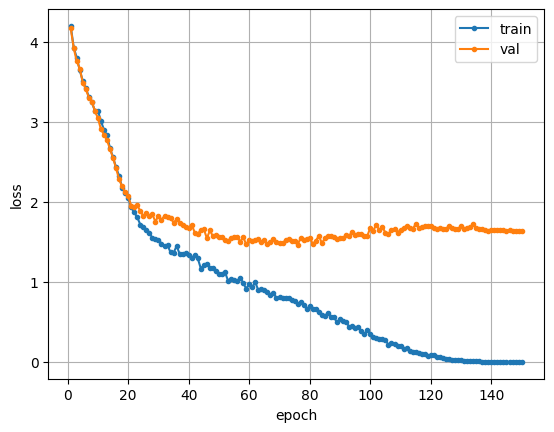

In [29]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['train loss']の長さまでの範囲）
xs = np.arange(1, len(history['train loss']) + 1)
# トレーニングデータの損失をプロット
ax.plot(xs, history['train loss'], '.-', label='train')
# バリデーションデータの損失をプロット
ax.plot(xs, history['val loss'], '.-', label='val')

ax.set_xlabel('epoch') # x軸のラベルを設定
ax.set_ylabel('loss') # y軸のラベルを設定
ax.legend() # 凡例を表示
ax.grid() # グリッドを表示
plt.show() # グラフを表示


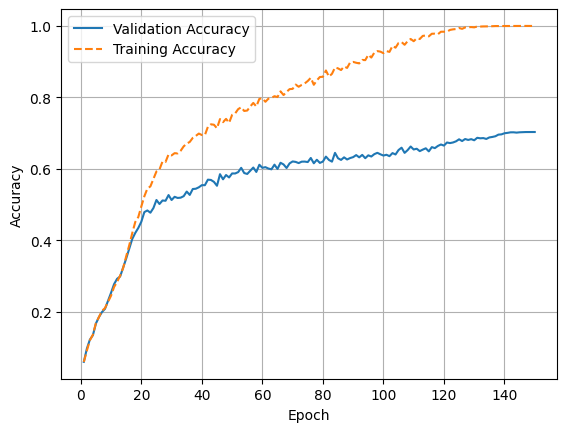

In [30]:
# グラフ描画用のFigureオブジェクトを作成
fig = plt.figure()
# Figureにサブプロット(1行1列の1つ目のプロット)を追加
ax = fig.add_subplot(111)
# x軸のデータをエポック数に基づいて作成（1からhistory['val acc']の長さまでの範囲）
xs = np.arange(1, len(history['val acc']) + 1)
# バリデーションデータの正解率をプロット
ax.plot(xs, history['val acc'], label='Validation Accuracy', linestyle='-')
# トレーニングデータの正解率をプロット
ax.plot(xs, history['train acc'], label='Training Accuracy', linestyle='--')
ax.set_xlabel('Epoch') # x軸のラベルを設定
ax.set_ylabel('Accuracy') # y軸のラベルを設定
ax.grid() # グリッドを表示
ax.legend()  # 凡例を追加
plt.show() # グラフを表示
